<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Use natural language to visualize U.S. Markets from Japan**


## Overview


近年、日本の個人投資家は、非課税投資枠(NISA)の導入により、米国の金融市場や株式が注目しています。ところが、日本に住んでいる間、アメリカ経済を体感するのは難しい。日本に住んでいる間にアメリカ株の投資タイミングを判断する方法はないのでしょうか。

前回は米国市場の強気（牛：Bull）と弱気（熊：Bear）を可視化することができたら、投資判断に使えるのではないかというのが、着眼点でした。
牛と熊、そしてLLMの羊が登場したので、次は鳥：BlackSwanです。

シカゴの指数でSKEWと呼ばれるものがあります。これはオプションを使っているため、市場のリスク回避の指標と言われており、通称ブラックスワン、黒い白鳥と言われています。今回はこのシカゴの黒い白鳥を可視化することができないか、というのがお題です。


このノートブックでは、IBMのデータサイエンス専門講座のオプション講座で教材となった、スキルブックを使用します。今私は文章を日本語で記載しています。教材は英語ですが、IBMのワトソンxでLLMにLlama3.1を使用しています。Llama3.1は標準で日本語も理解するので、日本語で命令文を記述しても米国のマーケットデータを可視化してくれます。

Objectives以降はところどころ日本語になっています。順にPythonを実行してみると、日本語を理解しながらLlamaがマーケットデータを可視化していく様子がよくわかると思います。

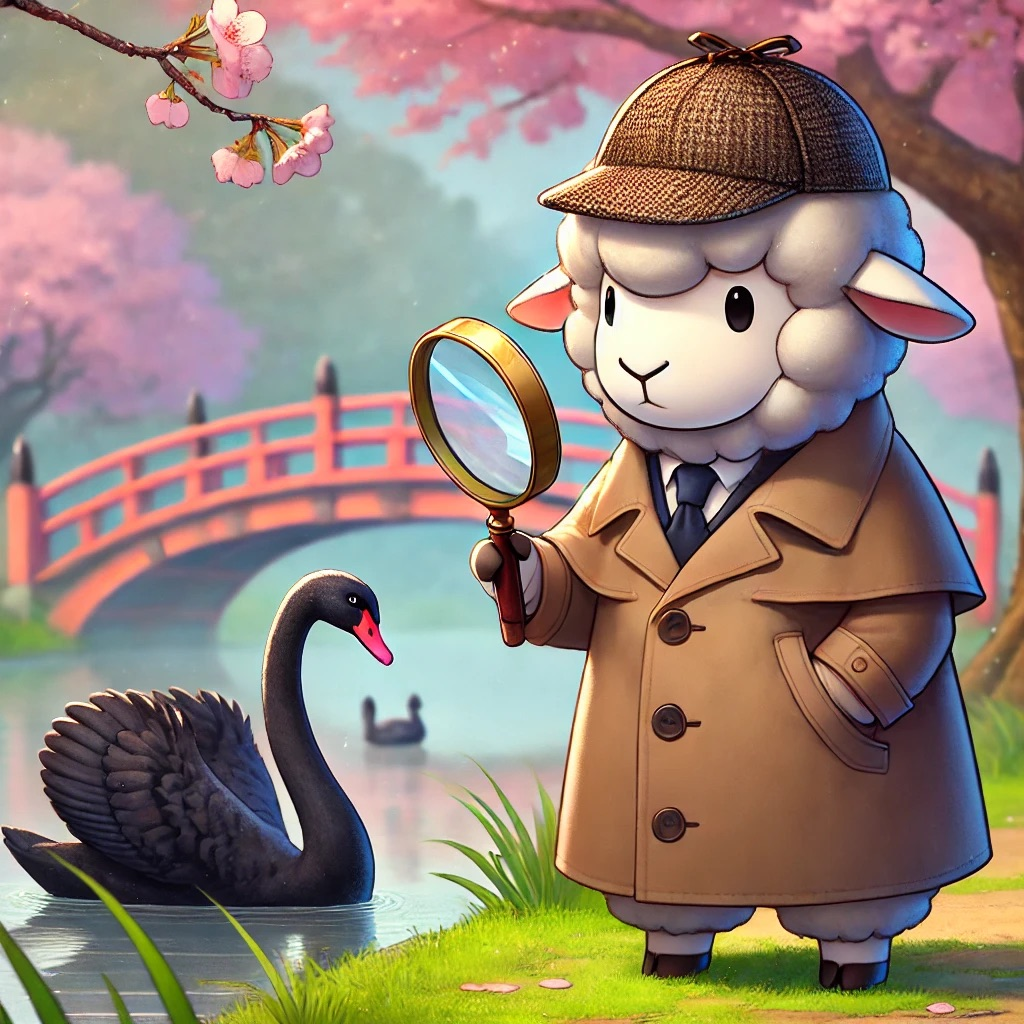

In [2]:
#ChatGPTで生成した、探偵の格好（Watson）をした羊（Llama）が、黒い白鳥（Blackswan）を見つける画像です。ジャパニーズアニメスタイル（Japanese Anime Style）で生成しています。
from IPython.display import Image
Image(filename='IMG_1346.jpeg')

---------


----


## Setup (IBM Skills Networkより)


This project is based on Jupyter Notebook. If you're not familiar with it, here's a quick guide on how to run code within it:

A Jupyter Notebook consists of cells. To execute a code cell, click on the cell that you want to run and click the 'Run' button, as shown in the picture.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IwbhiH3Wwv-VK-J4rioTAw/run.png" width="50%" alt="indexing"/>


In [ ]:
For this lab, we will be using the following libraries:

*   [`ibm-watson-ai`](https://ibm.github.io/watson-machine-learning-sdk/index.html) for using LLMs from IBM's watsonx.ai.
*   [`LangChain`, `langchain-ibm`, `langchain-experimental`](https://www.langchain.com/) for using its agent function to interact with data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.


### Installing required libraries

The following required libraries are __not__ preinstalled in the Skills Network Labs environment. __You must run the following cell__ to install them:

**Note:** We are pinning the version here to specify the version. It's recommended that you do this as well. Even if the library is updated in the future, the installed library could still support this lab work.

This might take approximately 1-2 minutes. 

As we use `%%capture` to capture the installation, you won't see the output process. But after the installation completes, you will see a number beside the cell.


In [1]:
%%capture
!pip install ibm-watsonx-ai=="0.2.6"
!pip install langchain=="0.1.16" 
!pip install langchain-ibm=="0.1.4"
!pip install langchain-experimental=="0.0.57"
!pip install matplotlib=="3.8.4"
!pip install seaborn=="0.13.2"



In [2]:
# We use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from ibm_watsonx_ai.foundation_models import Model
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

import matplotlib.pyplot as plt
import pandas as pd


## Data set


普段はYahoo!ファイナンスのCSVダウンロードを使用していました。ところが最近、CSVダウンロード機能が、フリーからゴールド会員に料金変更されてしまいました。

これは大変残念なので、代替としてGoogle Sheetのグーグルファイナンス関数を使います。こちらはシートなので、データを見ながら関数が使えますから、マーケットデータの準備には大変良いツールです。

牛Bullと熊Bearの可視化ができたので、今度は黒い白鳥：BlackSwanをやってみます。
予めGoogleシート上で、関数　=@googlefinance("SKEW","Date","Price","[Start Date]","[Close Date]","Daily")

SKEWは国債と違ってボラティリティがあります。前日比で2.5％より低く上昇している場合はややBlackswan（２）、それより上昇している時はとてもBlackswan（３）、マイナス2.5％は逆を示します（１）。それよりもマイナスは逆を示します（０）。逆相関ですので、（3）ほど、市場が警戒している指標になるんじゃないか。そんな風に考えてシート上で簡単な階層分けをしています。


これをCSVにダウンロードして、次のプログラムで読み取っています。

In [3]:
#あらかじめgoogle sheet 上でGoogleファイナンス関数を使ってデータ準備をする。今回のティッカーはSKEWです。市場と逆相関をする指数だと言われています。

df = pd.read_csv("SKEW.csv")


In [4]:
df.tail(20)



,Date,Close,DateGroup,Rate_To_PreviousDay,Bull_Bear
1237,2024/08/23 15:16:00,153.95,202408,-0.001362,1
1238,2024/08/26 15:16:00,151.50,202408,-0.015914,1
1239,2024/08/27 15:16:00,151.83,202408,0.002178,2
1240,2024/08/28 15:16:00,151.68,202408,-0.000988,1
1241,2024/08/29 15:16:00,153.01,202408,0.008768,2
1242,2024/08/30 15:16:00,159.00,202408,0.039148,3
1243,2024/09/03 15:16:00,163.60,202409,0.028931,3
1244,2024/09/04 15:16:00,160.90,202409,-0.016504,1
1245,2024/09/05 15:16:00,156.71,202409,-0.026041,0
1246,2024/09/06 15:16:00,148.98,202409,-0.049327,0


In [5]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1257 non-null   object 
 1   Close                1257 non-null   float64
 2   DateGroup            1257 non-null   int64  
 3   Rate_To_PreviousDay  1257 non-null   float64
 4   Bull_Bear            1257 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 49.2+ KB


In [6]:
# Create a dictionary to store credential information
credentials = {
    "url"    : "https://us-south.ml.cloud.ibm.com"
}

# Indicate the model we would like to initialize. In this case, Llama 3 70B.
model_id    = 'meta-llama/llama-3-70b-instruct'

# Initialize some watsonx.ai model parameters

params = {
        GenParams.MAX_NEW_TOKENS: 256, # The maximum number of tokens that the model can generate in a single run.
        GenParams.TEMPERATURE: 0,   # A parameter that controls the randomness of the token generation. A lower value makes the generation more deterministic, while a higher value introduces more randomness.
    }
project_id  = "****-*******" # <--- NOTE: specify your project_id
space_id    = None

verify      = False

# Launch a watsonx.ai model
model = Model(
    model_id=model_id, 
    credentials=credentials, 
    params=params, 
    project_id=project_id, 
    space_id=space_id, 
    verify=verify
)

# Integrate the watsonx.ai model with the langchain framework
llm = WatsonxLLM(model = model)

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=False,
    return_intermediate_steps=True  # set return_intermediate_steps=True so that model could return code that it comes up with to generate the chart
)

In [7]:
response = agent.invoke("このファイルの中にはいくつのデータが含まれていますか。")

In [8]:
response['output']

'このファイルの中には1257個のデータが含まれています。'

In [9]:
len(df)

1257

In [10]:
response['intermediate_steps'][0][0].tool_input.replace('; ', '\n')


'len(df)'

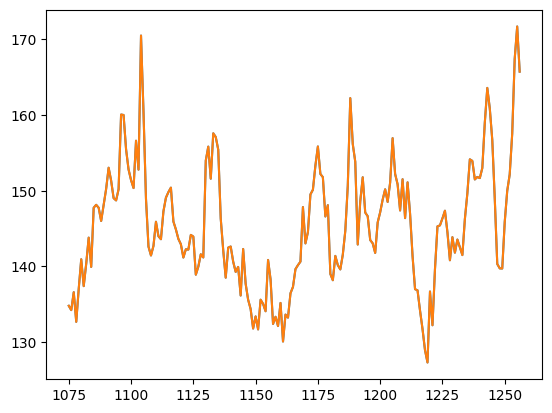

In [12]:
response = agent.invoke("2024年1月1日以降のCloseの値を時系列でラインチャートにしてください。")


In [13]:
print(response)

{'input': '2024年1月1日以降のCloseの値を時系列でラインチャートにしてください。', 'output': 'The line chart of Close values on or after 2024-01-01 has been successfully created.', 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="df[df['Date'] >= '2024-01-01']['Close'].plot(kind='line')", log="Thought: I need to filter the dataframe to only include rows where the date is on or after 2024-01-01. Then I can plot the Close column as a line chart.\nAction: python_repl_ast\nAction Input: df[df['Date'] >= '2024-01-01']['Close'].plot(kind='line')"), <Axes: >), (AgentAction(tool='python_repl_ast', tool_input="df['Date'] = pd.to_datetime(df['Date'])", log="2024年1月1日以降のデータが存在しないというエラーが出た。dfのDate列をdatetime型に変換して、2024年1月1日以降のデータを抽出する必要がある。\nAction: python_repl_ast\nAction Input: df['Date'] = pd.to_datetime(df['Date'])"), ''), (AgentAction(tool='python_repl_ast', tool_input="df[df['Date'] >= '2024-01-01']", log="2024年1月1日以降のデータを抽出する。\nAction: python_repl_ast\nAction Input: df[df['Date'] >= '2024-01-01']")

In [14]:
response['intermediate_steps'][0][0].tool_input.replace('; ', '\n')


"df[df['Date'] >= '2024-01-01']['Close'].plot(kind='line')"

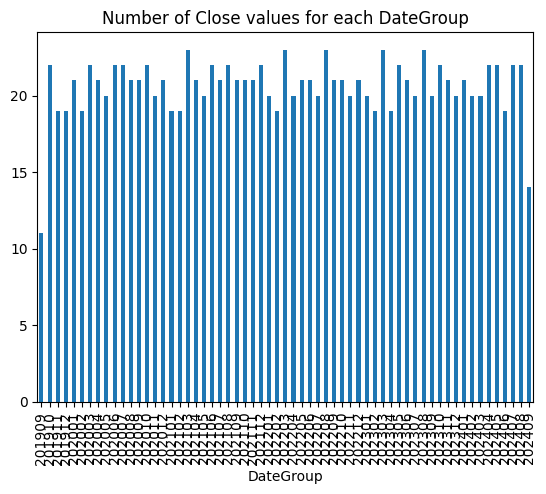

In [15]:
response = agent.invoke("DateGroupに含まれるCloseの日数をバーチャートにしてください。")

In [16]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))


df.groupby('DateGroup')['Close'].count().plot(kind='bar')


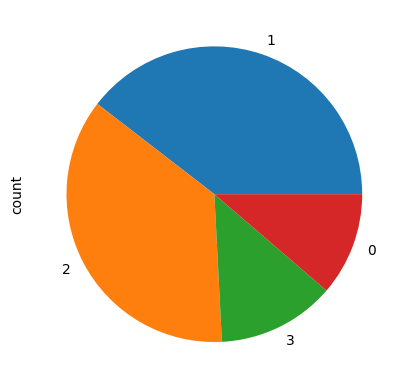

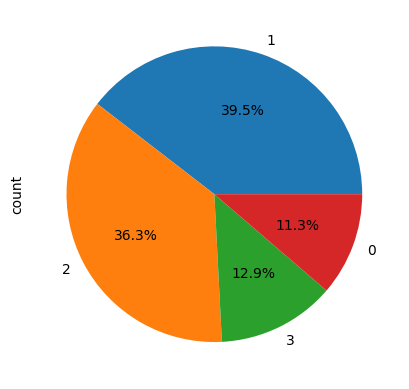

In [21]:
response = agent.invoke("Bull_Bearに含まれる0から3の度数をパイチャートにしてください。")



In [22]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))


import matplotlib.pyplot as plt
df['Bull_Bear'].value_counts().plot(kind='pie')
plt.show()


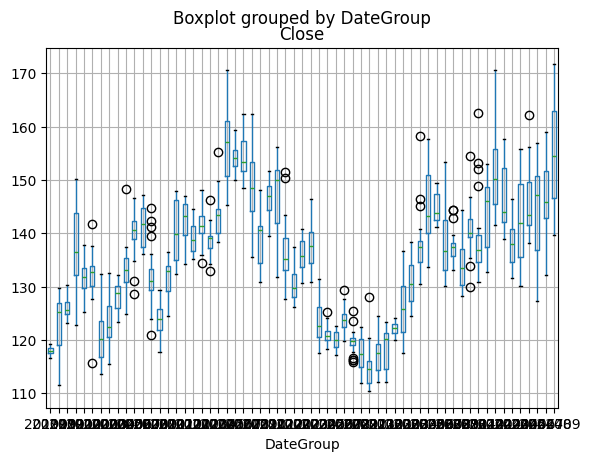

In [23]:
response = agent.invoke("DateGroupごとにCloseのボックスプロットを作成してください。")


In [25]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))

df.boxplot(column='Close', by='DateGroup')


In [22]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))


df[df['DateGroup'] >= 202309].plot.scatter(x='Date', y='Close')


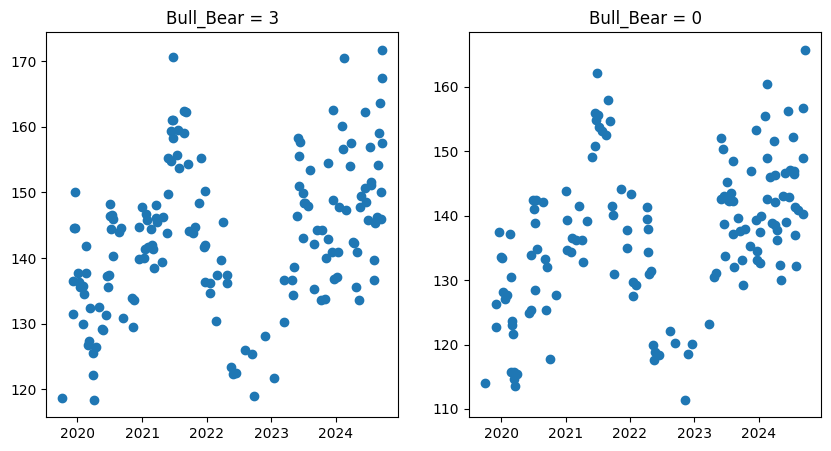

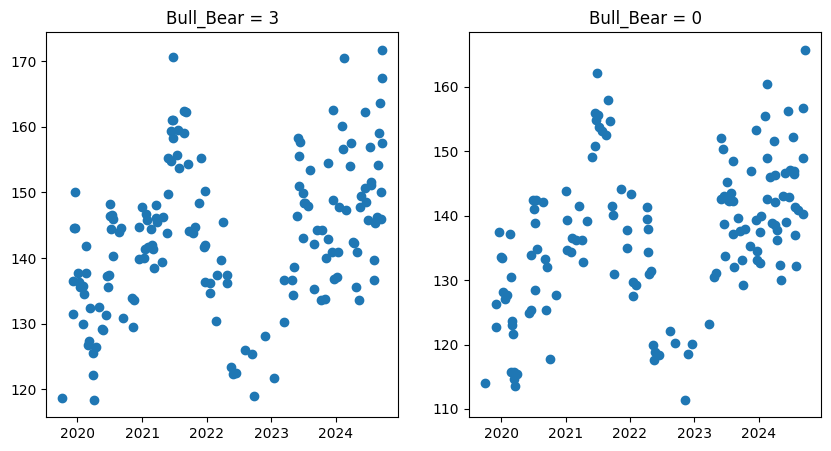

In [28]:
response = agent.invoke("Bull_Bearが3のデータを抜き出して、DateとCloseをスキャッタープロットにしてください。また、Bull_Bearが0のものを抜き出して、DateとCloseをスキャッタープロットにしてください。")



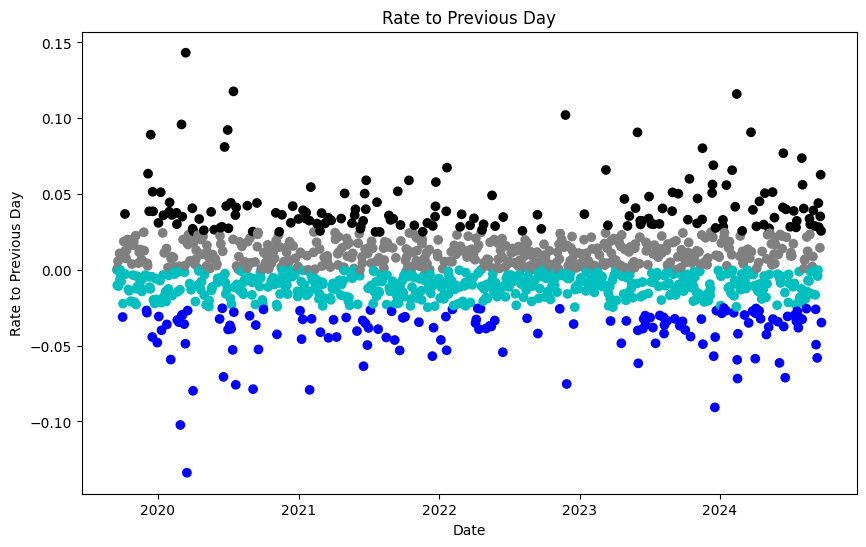

In [32]:
response = agent.invoke("Rate_To_PreviousDayの値をDate順に点でプロットしてください。Bull_Bearの値で0青・1水色・2灰色・3黒で色分けしてください。")



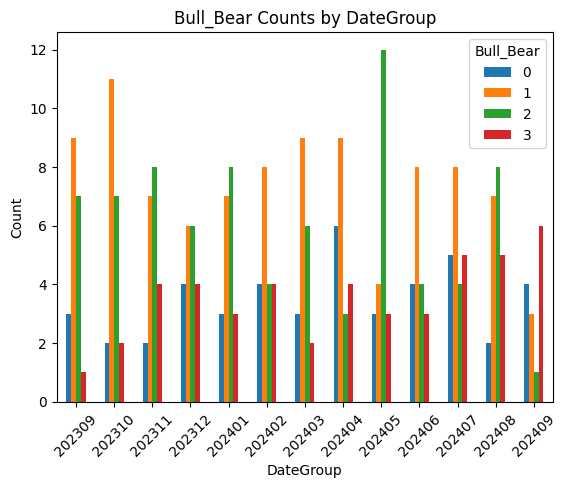

In [31]:
response = agent.invoke("2023年9月1日から現在までのデータについて、Bull_Bearの0から3のカウント数をDateGloupごとに棒グラフにして下さい。")



## Author


Yuya MORI

## Thanks to


Coursera & IBM Skills Network

[Kang Wang](https://author.skills.network/instructors/kang_wang)

Kang Wang is a Data Scientist in IBM. He is also a PhD Candidate in the University of Waterloo.


[Wojciech Fulmyk](https://author.skills.network/instructors/wojciech_fulmyk) <br>
Wojciech "Victor" Fulmyk is a Data Scientist at IBM. He is also a PhD Candidate in Economics in the University of Calgary.
